In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score

In [ ]:
# Load the dataset
data = pd.read_csv('/content/telco-customer-churn.csv')

In [ ]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
data.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [ ]:
# Data Preprocessing
# Impute Missing Values
data.ffill(inplace=True)
data.isnull().sum()

# Encode Categorical Variables
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

# Convert MonthlyCharges from float64 to int64
data['MonthlyCharges'] = data['MonthlyCharges'].astype('int64')
data.dtypes

,0
customerID,int64
gender,int64
SeniorCitizen,int64
Partner,int64
Dependents,int64
tenure,int64
PhoneService,int64
MultipleLines,int64
InternetService,int64
OnlineSecurity,int64


In [ ]:
# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(data.drop(columns='Churn'))
y = data['Churn']

# Address Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote=smote.fit_resample(X,y)

# SPlitting Training and Testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

In [ ]:
# 4. Model Training and Evaluation Function
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"--- {model_name} Performance ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-Score:", f1_score(y_test, y_pred))
    print()

# Models to Train
models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier( eval_metric='logloss')
}

# Initialize an empty list to store results
results = []

# Model training and evaluation without visualizations
for model_name, model in models.items():
    # Fit and predict on original data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics for original data
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store the results for original data
    results.append({
        'Model': model_name,
        'Data Type': 'Original',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

    # Fit and predict on SMOTE data
    model.fit(X_train_smote, y_train_smote)
    y_pred_smote = model.predict(X_test_smote)

    # Calculate metrics for SMOTE data
    accuracy_smote = accuracy_score(y_test_smote, y_pred_smote)
    precision_smote = precision_score(y_test_smote, y_pred_smote)
    recall_smote = recall_score(y_test_smote, y_pred_smote)
    f1_smote = f1_score(y_test_smote, y_pred_smote)

    # Store the results for SMOTE data
    results.append({
        'Model': model_name,
        'Data Type': 'SMOTE',
        'Accuracy': accuracy_smote,
        'Precision': precision_smote,
        'Recall': recall_smote,
        'F1-Score': f1_smote
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Display the results DataFrame
print("\nModel Evaluation Results:")
print(results_df)


Model Evaluation Results:
                 Model Data Type  Accuracy  Precision    Recall  F1-Score
0          Naive Bayes  Original  0.758694   0.530387  0.772118  0.628821
1          Naive Bayes     SMOTE  0.780193   0.770985  0.805529  0.787879
2  Logistic Regression  Original  0.814762   0.684211  0.557641  0.614476
3  Logistic Regression     SMOTE  0.790338   0.775785  0.824595  0.799445
4        Random Forest  Original  0.796309   0.654676  0.487936  0.559140
5        Random Forest     SMOTE  0.864251   0.862264  0.871306  0.866761
6              XGBoost  Original  0.779986   0.600000  0.506702  0.549419
7              XGBoost     SMOTE  0.856039   0.861405  0.853194  0.857280


In [ ]:
# Define the parameter grids for each model
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Initialize the models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Initialize RandomizedSearchCV for each model
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid,
                                      n_iter=20, cv=5, scoring='recall', random_state=42, n_jobs=-1)

xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_param_grid,
                                       n_iter=20, cv=5, scoring='recall', random_state=42, n_jobs=-1)

# Perform RandomizedSearchCV for Random Forest
rf_random_search.fit(X_train_smote, y_train_smote)
print("Best Parameters for Random Forest:", rf_random_search.best_params_)
best_rf_model = rf_random_search.best_estimator_

# Perform RandomizedSearchCV for XGBoost
xgb_random_search.fit(X_train_smote, y_train_smote)
print("Best Parameters for XGBoost:", xgb_random_search.best_params_)
best_xgb_model = xgb_random_search.best_estimator_

  # Evaluate tuned models
  print("\n--- Evaluation of Tuned Random Forest Model ---")
  evaluate_model(best_rf_model, X_train_smote, y_train_smote, X_test_smote, y_test_smote, model_name="Tuned Random Forest")

print("\n--- Evaluation of Tuned XGBoost Model ---")
evaluate_model(best_xgb_model, X_train_smote, y_train_smote, X_test_smote, y_test_smote, model_name="Tuned XGBoost")

Best Parameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': False}
Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.5}

--- Evaluation of Tuned Random Forest Model ---
--- Tuned Random Forest Performance ---
Accuracy: 0.8463768115942029
Precision: 0.8243123336291038
Recall: 0.8856053384175405
F1-Score: 0.8538602941176471


--- Evaluation of Tuned XGBoost Model ---
--- Tuned XGBoost Performance ---
Accuracy: 0.8449275362318841
Precision: 0.825
Recall: 0.880838894184938
F1-Score: 0.8520055325034578



In [ ]:
# Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Spectral", cbar=False)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Function to plot Precision-Recall Curve
def plot_precision_recall_curve(model, X_test, y_test, model_name):
    y_probs = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    plt.plot(recall, precision, label=f'{model_name}')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")
    plt.show()

Visualizations for Naive Bayes


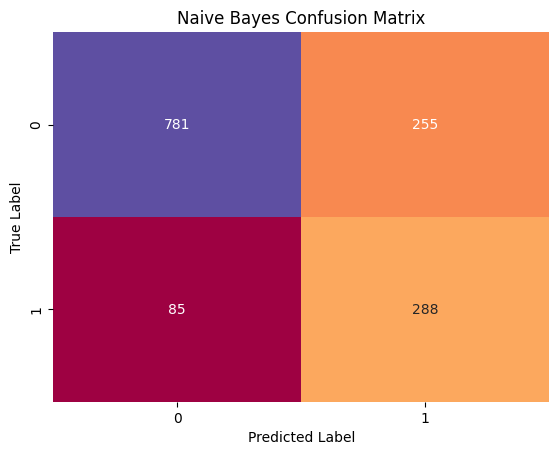

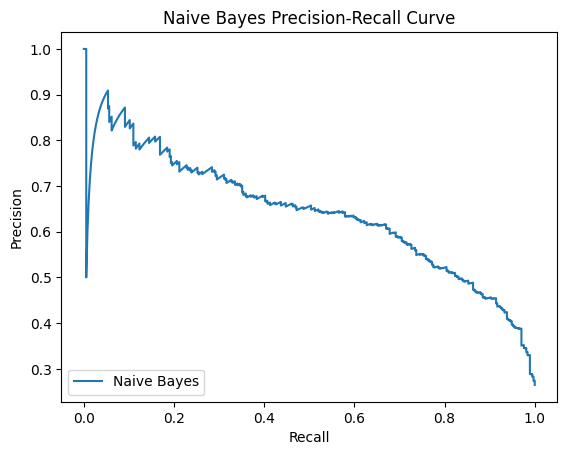

Visualizations for Naive Bayes (SMOTE)


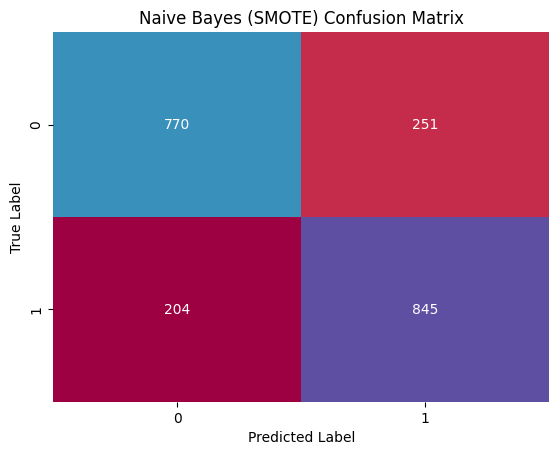

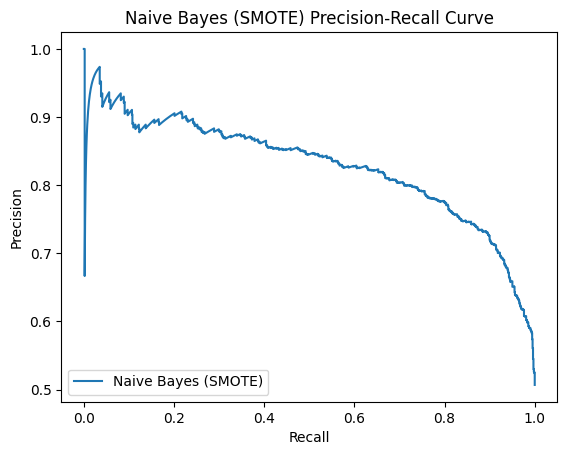

Visualizations for Logistic Regression


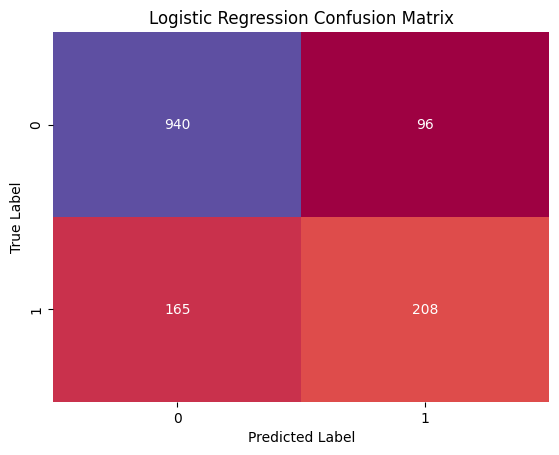

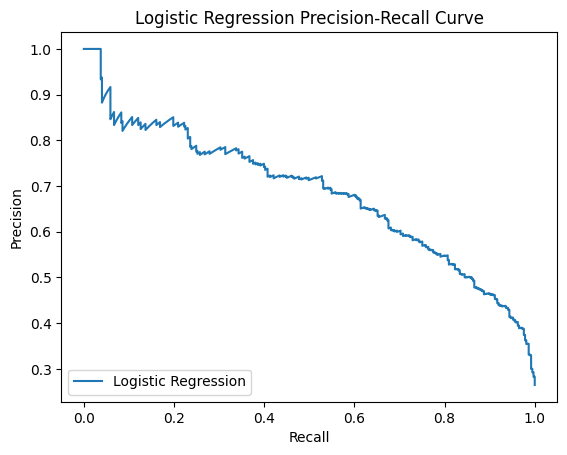

Visualizations for Logistic Regression (SMOTE)


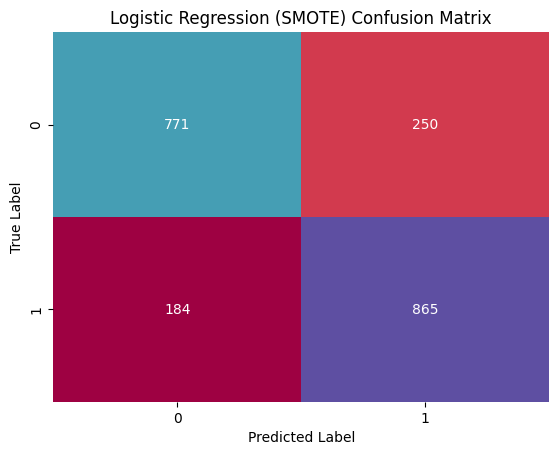

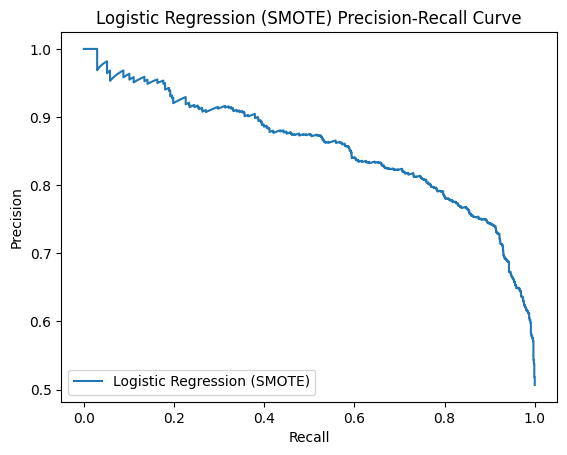

Visualizations for Random Forest


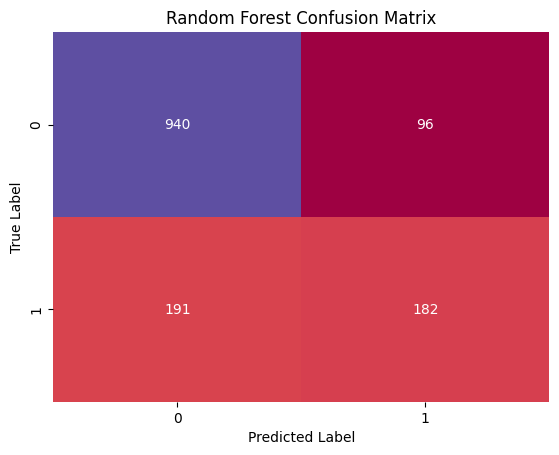

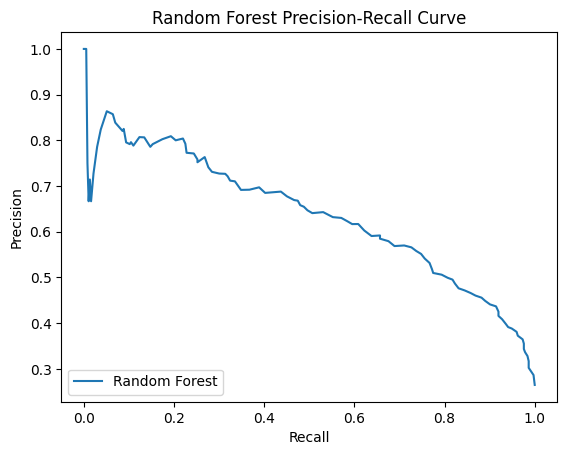

Visualizations for Random Forest (SMOTE)


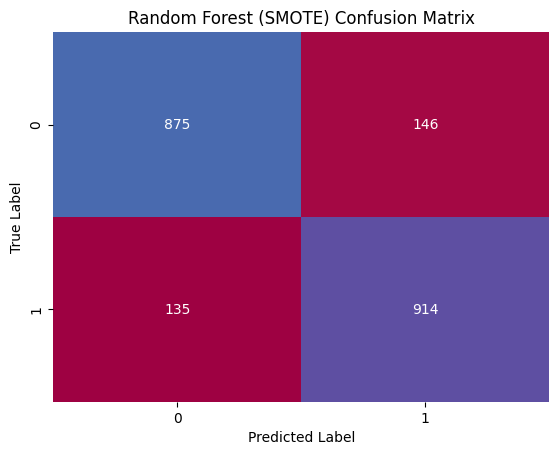

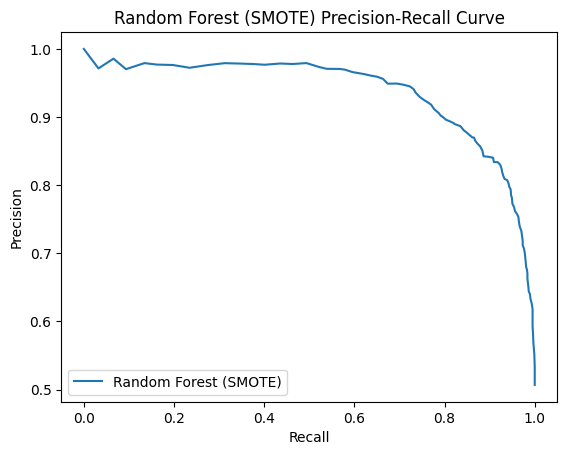

Visualizations for XGBoost


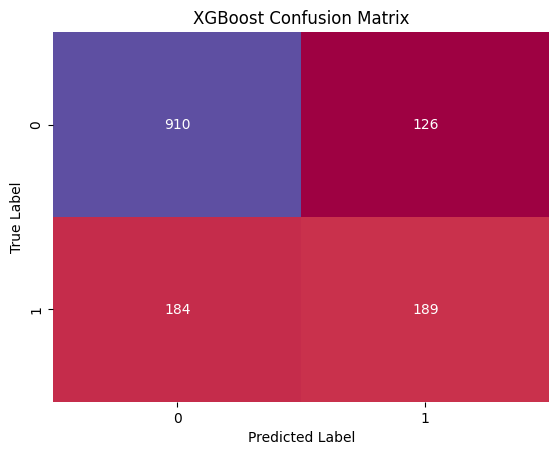

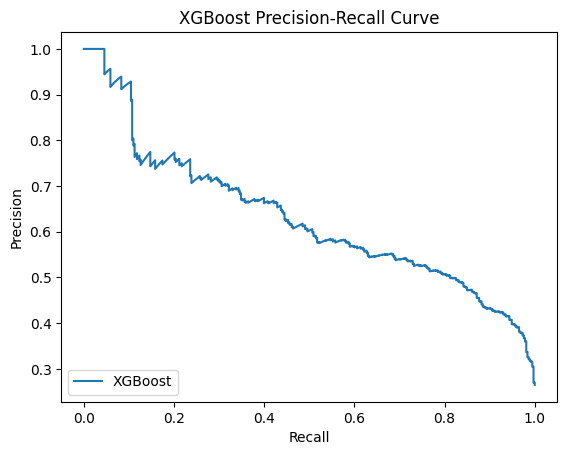

Visualizations for XGBoost (SMOTE)


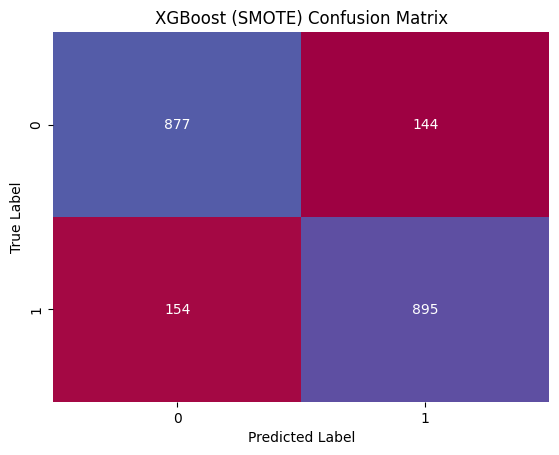

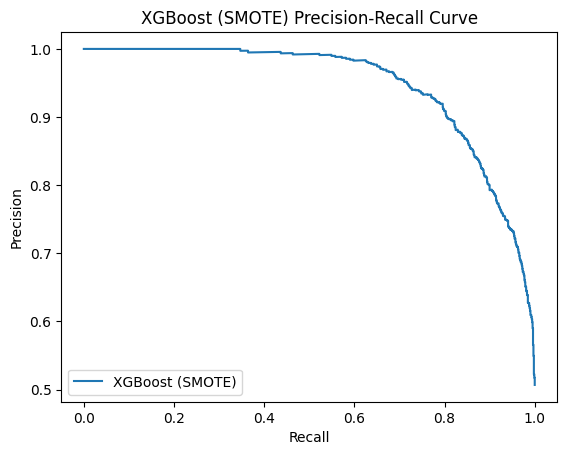

In [ ]:
# Plotting all visualizations for each model
for model_name, model in models.items():
    # Fit and predict on original data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Visualizations for {model_name}")
    plot_confusion_matrix(y_test, y_pred, model_name=model_name)
    plot_precision_recall_curve(model, X_test, y_test, model_name=model_name)

    # Fit and predict on SMOTE data
    model.fit(X_train_smote, y_train_smote)
    y_pred_smote = model.predict(X_test_smote)

    print(f"Visualizations for {model_name} (SMOTE)")
    plot_confusion_matrix(y_test_smote, y_pred_smote, model_name=model_name + " (SMOTE)")
    plot_precision_recall_curve(model, X_test_smote, y_test_smote, model_name=model_name + " (SMOTE)")

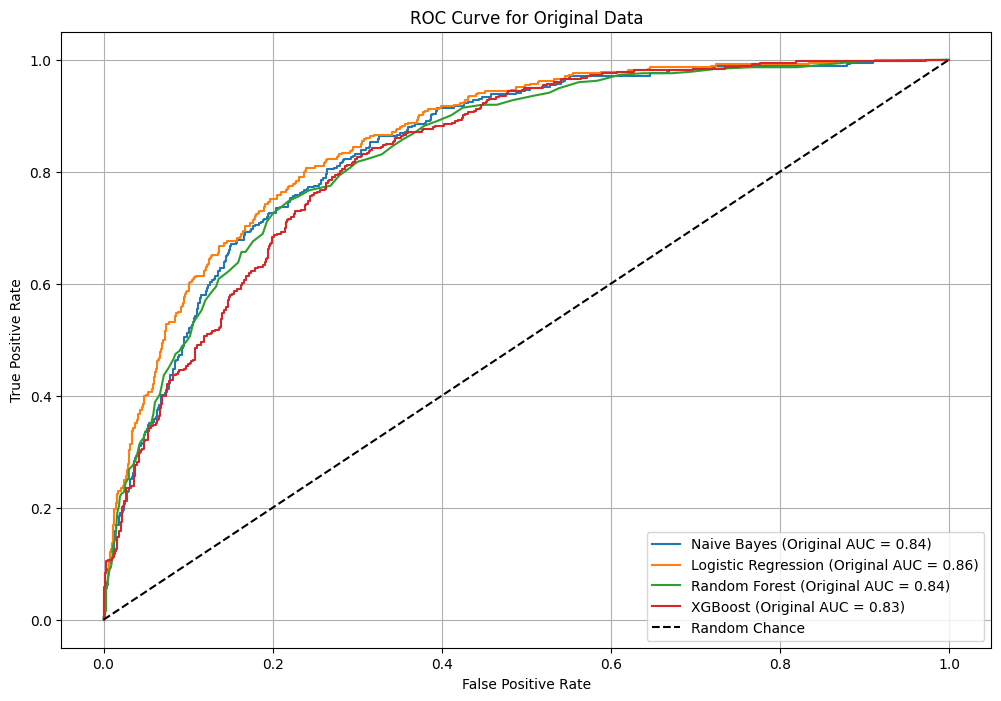

In [ ]:
# AUC for Original Data

plt.figure(figsize=(12, 8))
for model_name, model in models.items():
    model.fit(X_train, y_train)

    # Predict probabilities for the positive class
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_proba)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (Original AUC = {auc_score:.2f})')

# Plotting the diagonal line (chance)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Show the curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Original Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()


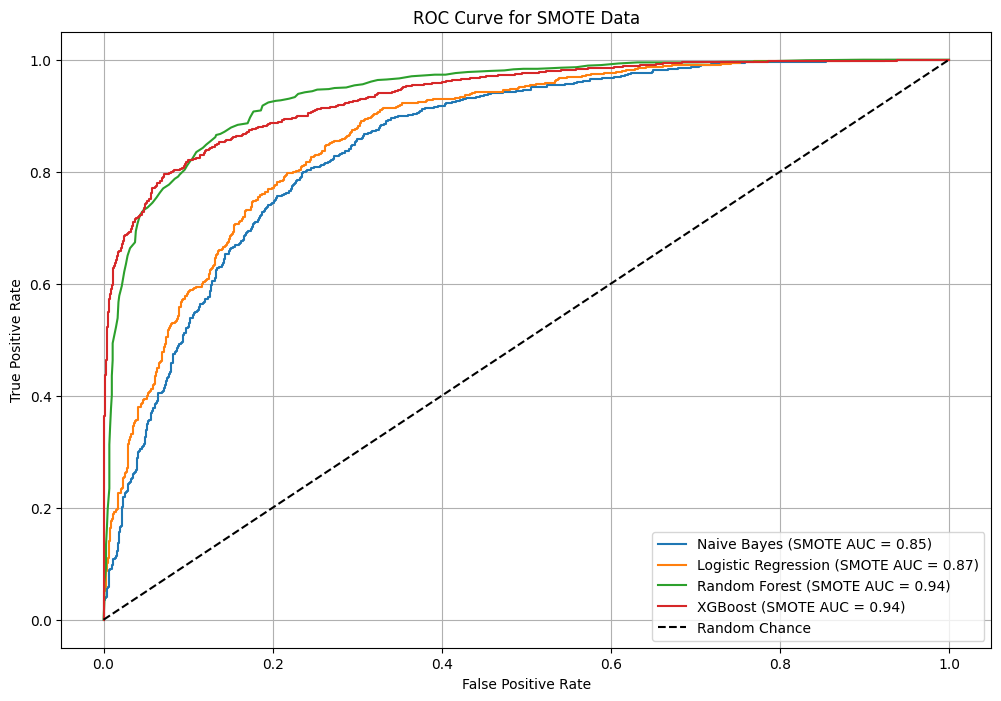

In [ ]:
# AUC for SMOTE Data

plt.figure(figsize=(12, 8))
for model_name, model in models.items():
    model.fit(X_train_smote, y_train_smote)

    # Predict probabilities for the positive class
    y_proba = model.predict_proba(X_test_smote)[:, 1]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_smote, y_proba)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test_smote, y_proba)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (SMOTE AUC = {auc_score:.2f})')

# Plotting the diagonal line (chance)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Show the curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SMOTE Data')
plt.legend(loc='lower right')
plt.grid()
plt.show()
